Bench_mark results

In [ ]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 15
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_learning_rate = 0.001
adam_epsilon = 1e-8
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)


def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=999):
    h = (b - a) / n
    integral_sum = func(a) + func(b)  
    
    for i in range(1, n):
        x_i = a + i * h
        if i % 3 == 0:
            integral_sum += 2 * func(x_i)  
        else:
            integral_sum += 3 * func(x_i) 
    
    integral_approximation = (3 * h / 8) * integral_sum
    return integral_approximation


def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
    val =  [torch.ones_like(param)* val for param in val_theta ]
    val_1  = [torch.ones_like(param)* val_1 for param in val_theta ]
    val_2  = [torch.ones_like(param)* val_2 for param in val_theta ]
    # sign_integrand = (-0.75)*(val_1**2)/(val**2) + (0.5)*(val_2/val)
    sign_integrand = [(-0.75)*(val_1[i]**2)/(val[i]**2) + (0.5)*(val_2[i]/val[i]) for i in range(len(val))]
    # sign = [1 if num > 0 else -1 for num in sign_integrand]
    # sign = [torch.ones_like(tensor) if tensor >= 0 else torch.full_like(tensor, -1) for tensor in sign_integrand]
    sign = [torch.tensor([[1 if num >= 0 else -1 for num in row] for row in (tensor.numpy()).reshape()]) for tensor in sign_integrand]
    
    result = [((-0.75) * ((2 * val_1[i] * (val[i] ** (-3)) * val_1_theta[i]) + (-3) * (val_1[i] ** 2) * ((val[i] ** (-4)) * val_theta[i])) +
          (0.5) * (((val[i] ** (-2)) * val_2_theta[i]) + ((-2) * (val[i] ** (-3)) * val_theta[i] * val_2[i])))*sign[i] for i in range(len(val))]
    return result
def Cab_derivative_wrt_param(integral_part_derivative_wrt_param):
    return constant_part*integral_part_derivative_wrt_param



class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Define the layers
        self.input_layer = nn.Linear(input_size, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.hidden_layer3 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.hidden_layer3(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0] 
        gradients_first_derivative = []
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0]
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        return output,grad_output,grad_grad_output
    def C_AB(self,):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        return self.C_AB() +  P[1]*(abs(output_time0 - omega_1)) +\
                          P[2]*(abs(grad_output_time0)) +\
                          P[3]*(abs(grad_grad_output_time0)) +\
                          P[4]*(abs(output_timetau - omega_2)) +\
                          P[5]*(abs(grad_output_timetau)) +\
                          P[6]*(abs(grad_grad_output_timetau)) +\
                          P[7]*function.reLU(output_time0-output_timetau)    
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 

def main():
    P_val = np.array([
    [1, 1, 1, 1, 1, 1, 16],
    [2, 2, 2, 2, 2, 2, 16],
    [4, 4, 4, 4, 4, 4, 16],
    [8, 8, 8, 8, 8, 8, 16]
])
    cost_fun = []
    bar = progressbar.ProgressBar(maxval=1000, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    for initial_conditions in range(1):
        bar.update(initial_conditions+1)
        net = CustomNet(input_size=1)
        parameters = list(net.parameters())
        loss_func_param_gradient = [torch.zeros_like(param) for param in parameters]
        cost_fun.append([])
        for pass_idx in range(1):
            m = [torch.zeros_like(param) for param in parameters]
            v = [torch.zeros_like(param) for param in parameters]
            t = -1
            for step in range(1000):
                t = t + 1
                n=999
                h = tau/999
                a = 0
                b = tau
                gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a = net.calculate_gradients_param(a)
                gradients_zeroth_derivative_b, gradients_first_derivative_b , gradients_second_derivative_b , output_b , grad_output_b , grad_grad_output_b  = net.calculate_gradients_param(b)
                
                for i in range(len(loss_func_param_gradient)):
                    
                    loss_func_param_gradient[i] = function_derivative_integrand(output_a.item(),grad_output_a.item(),grad_grad_output_a.item(),gradients_zeroth_derivative_a,gradients_first_derivative_a,gradients_second_derivative_a) + \
                    function_derivative_integrand(output_b.item(),grad_output_b.item(),grad_grad_output_b.item(),gradients_zeroth_derivative_b,gradients_first_derivative_b,gradients_second_derivative_b)
                    
                for integration_step in range(n):
                    x_i = a + integration_step * h
                    gradients_zeroth_derivative, gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output = net.calculate_gradients_param(x_i)
                    for i in range(len(loss_func_param_gradient)):    
                        if integration_step % 3 == 0:
                            loss_func_param_gradient[i] = loss_func_param_gradient[i] + 2*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[0],gradients_first_derivative[0],gradients_second_derivative[0])
                        else:
                            loss_func_param_gradient[i] = loss_func_param_gradient[i] + 3*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[0],gradients_first_derivative[0],gradients_second_derivative[0])
                
                for j in range(len(loss_func_param_gradient)):    
                    loss_func_param_gradient[j] = (3 * h / 8) * loss_func_param_gradient[j]  
                net.add
                for i in range(len(loss_func_param_gradient)):    
                    m[i] = adam_beta_1 * m[i] + (1 - adam_beta_1) * loss_func_param_gradient[i] 
                    v[i] = adam_beta_2 * v[i] + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2)

                    # Compute bias-corrected moment estimates
                    m_hat = m[i] / (1 - adam_beta_1**t)
                    v_hat = v[i] / (1 - adam_beta_2**t)
                    parameters[i] = parameters[i] - adam_learning_rate * m_hat / (torch.sqrt(v_hat) + adam_epsilon)
                i = 0    
                with torch.no_grad():
                    for param in net.parameters():
                        param = parameters[i]
                        i = i + 1
    
                cost_fun[initial_conditions].append(net.cost_function(P_val[0]))

    with open('parrot.pkl', 'wb') as f:
        pickle.dump(cost_fun, f)



if __name__ == "__main__":
    main()


In [ ]:
sign_integrand

In [ ]:
import torch

# Example input tensor (replace this with your own tensor)
input_tensor = torch.tensor([[2, -3, 1], [-4, 5, -6]])

# Create a new tensor with the same shape as the input
output_tensor = torch.where(input_tensor > 0, torch.tensor(1), torch.tensor(-1))

# Print the result
print(output_tensor)


In [ ]:
A = np.array([[1], [2], [3], [4]])  # A is of shape (4, 1)
B = np.array([[11, 12,  13,  14],
              [20,  30,  40,  50],
              [10,  20,  100,  200],
              [ 10,  20,  100,  200]])  # B is of shape (4, 4)
result  = A*B
result

In [ ]:
def polynomial_ansatz( t ):
  w1 = 0.1
  w2 = 0.5
  a3 = 10.0
  a4 = -15.0
  a5 = 6.0
  tau = 2
  return w1 + (w2 - w1)*( a3*((t/tau)**3) + a4*((t/tau)**4) + a5*((t/tau)**5) )
# polynomial_ansatz(w1 , w2 , a3 , a4 , a5 , t)

In [ ]:
t_val = np.arange(0,2,0.01)
w_val = []
for t in t_val:
  w_val.append(polynomial_ansatz( t ))
w_val = np.array(w_val)

In [ ]:
df_polynomial_ansatz = nd.Derivative(polynomial_ansatz, n=1)
dw_val = df_polynomial_ansatz(t_val)

In [ ]:
ddf_polynomial_ansatz = nd.Derivative(polynomial_ansatz, n=2)
ddw_val = ddf_polynomial_ansatz(t_val)

In [ ]:
t_val_normalized = []
for i in t_val:
  t_val_normalized.append(i/2)
t_val_normalized = np.array(t_val_normalized)

In [ ]:
plt.figure(figsize=(15,7.5))
plt.grid(True)
plt.plot(t_val_normalized,w_val)
plt.plot(t_val_normalized,dw_val)
plt.plot(t_val_normalized,ddw_val)

In [ ]:
def lcd_freq(w , w_1, w_2):
  return w**2 - ( 3*( (w_1)**2 )/( 4*( (w)**2 ) ) ) + ( w_2 / (2*w) )

In [ ]:
lcd_freq_val = []
for i in range(t_val.shape[0]):
  lcd_freq_val.append( ( lcd_freq( w_val[i] , dw_val[i] , ddw_val[i] ) )**0.5 )
lcd_freq_val = np.array(lcd_freq_val)

In [ ]:
plt.plot(t_val,lcd_freq_val)

Neural network implementation

In [ ]:
def init_params():
  W1 = np.random.rand(100 , 1) - 0.5
  gradient_W1 = np.zeros((100 , 1))
  W2 = np.random.rand(100, 100) - 0.5
  gradient_W2 = np.zeros((100 , 100))
  W3 = np.random.rand(100, 100) -0.5
  gradient_W3 = np.zeros((100 , 100))
  W4 = np.random.rand(1, 100) - 0.5
  gradient_W4 = np.zeros((1 , 100))
  b1 = np.random.rand(100, 1) - 0.5
  gradient_b1 = np.zeros((100 , 1))
  b2 = np.random.rand(100, 1) - 0.5
  gradient_b2 = np.zeros((100 , 1))
  b3 = np.random.rand(100, 1) -0.5
  gradient_b3 = np.zeros((100 , 1))
  b4 = np.random.rand(1,1) - 0.5
  gradient_b4 = np.zeros((1, 1))
  return W1, W2, W3, W4, b1, b2, b3, b4 ,gradient_W1 ,gradient_W2 ,gradient_W3 ,gradient_W4,gradient_b1,gradient_b2,gradient_b3,gradient_b4

def reLU(val):
  return np.maximum(0, val)

def sigmoid(val_array):
  activated_layer  = np.zeros_like(val_array)
  for i in range(val_array.shape[0]):
    activated_layer[i][0] = 1/(1+np.exp(-val_array[i][0]))
  return activated_layer
def forward_propogation(t, W1, W2, W3, W4, b1, b2, b3, b4, cache_nodes):
  if(cache_nodes):
    A1 = np.add(np.matmul(W1,t) , b1)
    layer1 =  sigmoid(A1)
    A2 = np.add(np.matmul(W2,layer1) , b2)
    layer2 =  sigmoid(A2)
    A3 = np.add(np.matmul(W3,layer2) , b3)
    layer3 =  sigmoid(A3)
    A4 = np.add(np.matmul(W4,layer3) , b4)
    output =  sigmoid(A4)
    return A1,layer1,A2,layer2,A3,layer3,A4,output
  else:
     return sigmoid(np.add(np.matmul(W4,sigmoid(np.add(np.matmul(W3,sigmoid(np.add(np.matmul(W2,sigmoid(np.add(np.matmul(W1,t) , b1))) , b2))) , b3))) , b4))

def loss_function():

def calculate_gradients():
# reverse autoderivative
  
def adam_optimizatoin(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):


    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary

    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] /(1 - beta1 ** t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] /(1 - beta1 ** t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (np.square(grads["dW" + str(l+1)]) )
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (np.square(grads["db" + str(l+1)]) )

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] /(1 - beta2 ** t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] /(1 - beta2 ** t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate *  v_corrected["dW" + str(l+1)] /(np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters, v, s

In [ ]:
for i in range(100):
    x = np.random.rand(1 , 1)
    print(x)

In [ ]:
val_array = np.array([[1, 2, 3], [4, 5, 6]])
activated_layer  = np.zeros_like(val_array)
activated_layer

In [ ]:

def _get_params(value):
    if isinstance(value, Parameter):
        return [value]
    if isinstance(value, dict):
        params = []
        for k, v in value.items():
            params += _get_params(v)
        return params
    if isinstance(value, Module):
        return value.parameters()
    return []

class Module:
    def parameters(self):
        return _get_params(self.__dict__)

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [ ]:
class MultiPathScaleAdd(Module):
    def __init__(self):
        self.path0 = ScaleAdd()
        self.path1 = ScaleAdd()

    def forward(self, x):
        return self.path0(x) + self.path1(x)

In [ ]:
x = np.random.rand(1 , 1)
y = np.random.rand(4 , 1)
one_array = np.array([[1], [1] , [1] , [1]])
x.shape  , y.shape , np.matmul(x,y.transpose()).transpose() + one_array

In [ ]:
y = np.random.rand(4 , 1)
y

In [ ]:
x_1 = x-0.5

In [ ]:
x_1[0]

In [ ]:
def main():
    P_val = np.zeros((4,7))
    for initial_conditions in range(1000):
        W1, W2, W3, W4, b1, b2, b3, b4 ,gradient_W1 ,gradient_W2 ,gradient_W3 ,gradient_W4,gradient_b1,gradient_b2,gradient_b3,gradient_b4 = init_params()
        NN = Neural_network(W1, W2, W3, W4, b1, b2, b3, b4 ,gradient_W1 ,gradient_W2 ,gradient_W3 ,gradient_W4,gradient_b1,gradient_b2,gradient_b3,gradient_b4)
        del
        for passes in range(4):
            for epoch in range (1000):
                calculate_gradients()
    

                

In [ ]:
class Neural_network:
    def __init__(self,W1, W2, W3, W4, b1, b2, b3, b4 ,gradient_W1 ,gradient_W2 ,gradient_W3 ,gradient_W4,gradient_b1,gradient_b2,gradient_b3,gradient_b4):
        self.W1 = W1
        self.gradient_W1 = gradient_W1
        self.W2 = W2
        self.gradient_W2 = gradient_W2
        self.W3 = W3
        self.gradient_W3 = gradient_W3
        self.W4 = W4
        self.gradient_W4 = gradient_W4
        self.b1 = b1
        self.gradient_b1 = gradient_b1
        self.b2 = b2
        self.gradient_b2 = gradient_b2
        self.b3 = b3
        self.gradient_b3 = gradient_b3
        self.b4 = b4
        self.gradient_b4 = gradient_b4

NN = Neural_network()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
start_time = time.time()



class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Define the layers
        self.input_layer = nn.Linear(input_size, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.hidden_layer3 = nn.Linear(100, 1)
        self.output_layer = nn.Linear(1, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.hidden_layer3(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# Create an instance of the custom neural network with input size 1
# net = CustomNet(input_size=1).to(device)
net = CustomNet(input_size=1)
parameters = list(net.parameters())

# matrix_list = [torch.randn_like(param) for param in parameters]



In [ ]:
net.forward(torch.tensor([[1]], dtype=torch.float32, requires_grad=True)).item()

In [ ]:
loss_func_param_gradient =  [torch.randn_like(param) for param in parameters]


In [ ]:
len(loss_func_param_gradient)

In [ ]:
for i in range(len(parameters)):
    # print(parameters[i].shape[0])
    # print(parameters[i].shape[1])
    print(gradients_zeroth_derivative[i].shape)
    # print(matrix_list[i].shape)

In [ ]:
import torch 
import numpy
num = np.random.rand(1 , 1)[0][0] - 0.5

# Example input tensor with shape (batch_size, input_size)
# input_data = torch.tensor([[num]], dtype=torch.float32, requires_grad=True).to(device)
input_data = torch.tensor([[num]], dtype=torch.float32, requires_grad=True)
# Forward pass through the network
output = net(input_data)
#####
parameters = list(net.parameters())
gradients_zeroth_derivative = []
for param in parameters:
    gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
    gradients_zeroth_derivative.append(gradient_0th[0])
#####
grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0]
####
# Calculate the gradients of the derivative with respect to network parameters (weights and biases)
gradients_first_derivative = []
for param in parameters:
    gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
    gradients_first_derivative.append(gradient_1st[0])
####
grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
# Compute the gradients of the second derivative with respect to network parameters (weights and biases)
gradients_second_derivative = []
for param in parameters:
    gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
    gradients_second_derivative.append(gradient_2nd[0])

In [ ]:
type(grad_grad_output.item())

In [ ]:
for i in range(len(parameters)):
    # print(parameters[i].shape[0])
    # print(parameters[i].shape[1])
    print(gradients_zeroth_derivative[i].shape)
    # print(matrix_list[i].shape)

In [ ]:
gradients_zeroth_derivative[0][0].shape

In [ ]:
len(gradients_zeroth_derivative)

In [ ]:
type(parameters[0])
# tensor([[-0.2419],
        # [ 0.0420],


In [ ]:
# latest code checks

In [ ]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 15
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=9999):
    if n % 3 != 0:
        raise ValueError("The number of subintervals (n) must be a multiple of 3.")
    
    h = (b - a) / n
    integral_sum = func(a) + func(b)  
    
    for i in range(1, n):
        x_i = a + i * h
        if i % 3 == 0:
            integral_sum += 2 * func(x_i)  
        else:
            integral_sum += 3 * func(x_i) 
    
    integral_approximation = (3 * h / 8) * integral_sum
    return integral_approximation

def Integral_function(val,val_1,val_2,sign=False):
  if (sign):
    if (( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) > 0):
        return 1
    else :
        return -1
  else:    
    return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 

def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
    val = torch.ones_like(val_theta) * val
    val_1 = torch.ones_like(val_theta) * val_1
    val_2 = torch.ones_like(val_theta) * val_2
    return ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
          (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))
def C_AB(self):
   Integral_part = simpsons_3_8_rule_integration(self.Integral_function , b = tau)
   return constant_part*Integral_part

def cost_function(self):
    return self.C_AB() +  self.P[1]*(abs(self.forward_pass(0) - omega_1)) +\
                          self.P[2]*(abs(self.forward_pass_first_derivative(0))) +\
                          self.P[3]*(abs(self.forward_pass_second_derivative(0))) +\
                          self.P[4]*(abs(self.forward_pass(tau) - omega_2)) +\
                          self.P[5]*(abs(self.forward_pass_first_derivative(tau))) +\
                          self.P[6]*(abs(self.forward_pass_second_derivative(tau))) +\
                          self.P[7]*function.reLU(self.forward_pass(0)-self.forward_pass(tau))   
class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Define the layers
        self.input_layer = nn.Linear(input_size, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.hidden_layer3 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.hidden_layer3(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0] 
        gradients_first_derivative = []
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output


P_val = np.array([
    [1, 1, 1, 1, 1, 1, 16],
    [2, 2, 2, 2, 2, 2, 16],
    [4, 4, 4, 4, 4, 4, 16],
    [8, 8, 8, 8, 8, 8, 16]
])


    
for initial_conditions in range(1):
        net = CustomNet(input_size=1)
        parameters = list(net.parameters())
        gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a = net.calculate_gradients_param(0.5)
        print(1)





In [ ]:
output_a.item()

In [ ]:
for i in range(10):
    print(gradients_zeroth_derivative_a[i].shape)

In [ ]:
for i in range(1):
    print(1)

In [ ]:
f = function_derivative_integrand(output_a.item(),grad_output_a.item(),grad_grad_output_a.item(),gradients_zeroth_derivative_a[0],gradients_first_derivative_a[0],gradients_second_derivative_a[0])
f.shape

In [ ]:
gradients_zeroth_derivative_a[0].shape,gradients_first_derivative_a[0].shape,gradients_second_derivative_a[0].shape


In [ ]:
output_a.item(),grad_output_a.item(),grad_grad_output_a.item()

In [ ]:
# Suppose you have a simple neural network with two parameters
param1 = torch.tensor([0.5, -0.3], requires_grad=True)
param2 = torch.tensor([1.0, 0.8], requires_grad=True)

# You collect these parameters into a list
parameters = [param1, param2]

# Initialize m and v with the same shape as the parameters, all zeros
m = [torch.zeros_like(param) for param in parameters]
v = [torch.zeros_like(param) for param in parameters]


In [ ]:
with torch.no_grad():
    for param in net.parameters():
        print(param.shape)


In [ ]:
import torch

# PyTorch tensors
val_theta = gradients_zeroth_derivative_a[0]
val_1_theta = gradients_first_derivative_a[0]
val_2_theta = gradients_second_derivative_a[0]

# Scalar float values
val = 0.5
val_1 = -2.5406008717254736e-05
val_2 = 3.248344910389278e-06

# Convert scalar values to tensors with the same shape
val = torch.ones_like(val_theta) * val
val_1 = torch.ones_like(val_theta) * val_1
val_2 = torch.ones_like(val_theta) * val_2

# Perform element-wise operation
result = ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
          (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))

print(result.shape)


In [ ]:
((2 * val_1 * (val ** (-3)) * val_1_theta)).shape

In [ ]:
type(val_1)

In [ ]:
gradients_zeroth_derivative_a[0].shape,gradients_first_derivative_a[0].shape,gradients_second_derivative_a[0].shape

In [ ]:
class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Define the layers
        self.input_layer = nn.Linear(input_size, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.hidden_layer3 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.hidden_layer3(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0] 
        gradients_first_derivative = []
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0]
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        return output,grad_output,grad_grad_output
    def C_AB(self,):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
        return self.C_AB() +  P[0]*(abs(output_time0 - omega_1)) +\
                          P[1]*(abs(grad_output_time0)) +\
                          P[2]*(abs(grad_grad_output_time0)) +\
                          P[3]*(abs(output_timetau - omega_2)) +\
                          P[4]*(abs(grad_output_timetau)) +\
                          P[5]*(abs(grad_grad_output_timetau)) +\
                          P[6]*reLU(output_time0-output_timetau)    
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 


In [ ]:
def reLU(val):
  return np.maximum(0, val)

In [ ]:
output_time0,grad_output_time0,grad_grad_output_time0 = net.gradients_wrt_time(0)

In [ ]:
output_time0.item()

In [ ]:
P_val = np.array([
    [1, 1, 1, 1, 1, 1, 16],
    [2, 2, 2, 2, 2, 2, 16],
    [4, 4, 4, 4, 4, 4, 16],
    [8, 8, 8, 8, 8, 8, 16]
])
net = CustomNet(input_size=1)
net.cost_function(P_val[0])

In [ ]:
loaded_list[0]

In [131]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

def sign_val(a):
    if(a>=0):
        return 1
    else:
        return 0
def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 15
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_learning_rate = 0.0000001
adam_epsilon = 1e-8
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

def reLU(val):
  return np.maximum(0, val)
def reLU_derivative(z):
    if(z>0):
        return 1
    if(z<0):
        return 0
    if(z==0):
        print("z = 0 , NN is giving same value at both zero and tau ")
def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=999):
    h = (b - a) / n
    integral_sum = func(a) + func(b)  
    
    for i in range(1, n):
        x_i = a + i * h
        if i % 3 == 0:
            integral_sum += 2 * func(x_i)  
        else:
            integral_sum += 3 * func(x_i) 
    
    integral_approximation = (3 * h / 8) * integral_sum
    return integral_approximation


def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
    val = torch.ones_like(val_theta) * val
    val_1 = torch.ones_like(val_theta) * val_1
    val_2 = torch.ones_like(val_theta) * val_2
    sign_integrand = (-0.75)*(val_1**2)/(val**2) + (0.5)*(val_2/val)
    sign = torch.where(sign_integrand > 0, torch.tensor(1), torch.tensor(-1))
    
    return ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
          (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))*sign
def Cab_derivative_wrt_param(integral_part_derivative_wrt_param):
    return constant_part*integral_part_derivative_wrt_param



class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # Define the layers
        self.input_layer = nn.Linear(1, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0] 
        gradients_first_derivative = []
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0]
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        return output,grad_output,grad_grad_output
    def C_AB(self,):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
        return self.C_AB() + P[0]*(abs(output_time0 - omega_1)) +\
                          P[1]*(abs(grad_output_time0)) +\
                          P[2]*(abs(grad_grad_output_time0)) +\
                          P[3]*(abs(output_timetau - omega_2)) +\
                          P[4]*(abs(grad_output_timetau)) +\
                          P[5]*(abs(grad_grad_output_timetau)) +\
                          P[6]*reLU(output_time0-output_timetau)    
        # return self.C_AB()
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
   
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 


P_val = np.array([
    [1, 1, 1, 1, 1, 1, 16],
    [2, 2, 2, 2, 2, 2, 16],
    [4, 4, 4, 4, 4, 4, 16],
    [8, 8, 8, 8, 8, 8, 16]
])
cost_fun = []
bar = progressbar.ProgressBar(maxval=1000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for initial_conditions in range(10):
    bar.update(initial_conditions+1)
    net = CustomNet()
    parameters = list(net.parameters())
    loss_func_param_gradient = [torch.zeros_like(param) for param in parameters]
    cost_fun.append([])
    for pass_idx in range(1):
        m_curr = [torch.zeros_like(param) for param in parameters]
        v_curr = [torch.zeros_like(param) for param in parameters]
        m_prev = [torch.zeros_like(param) for param in parameters]
        v_prev = [torch.zeros_like(param) for param in parameters]
        t = 0
        P = P_val[pass_idx]
        # for i in range (len(m)):
        #     print(m_curr[i].shape)
        for step in range(50):
            t = t + 1
            n=99
            h = tau/n
            a = 0
            b = tau
            gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a = net.calculate_gradients_param(a)
            gradients_zeroth_derivative_b, gradients_first_derivative_b , gradients_second_derivative_b , output_b , grad_output_b , grad_grad_output_b  = net.calculate_gradients_param(b)
            
            for i in range(len(loss_func_param_gradient)):
                
                loss_func_param_gradient[i] = function_derivative_integrand(output_a.item(),grad_output_a.item(),grad_grad_output_a.item(),gradients_zeroth_derivative_a[i],gradients_first_derivative_a[i],gradients_second_derivative_a[i]) + \
                function_derivative_integrand(output_b.item(),grad_output_b.item(),grad_grad_output_b.item(),gradients_zeroth_derivative_b[i],gradients_first_derivative_b[i],gradients_second_derivative_b[i])
            for integration_step in range(n):
                x_i = a + integration_step * h
                gradients_zeroth_derivative, gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output = net.calculate_gradients_param(x_i)
                for i in range(len(loss_func_param_gradient)):    
                    if (integration_step+1) % 3 == 0:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 2*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
                    else:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 3*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
            
            for j in range(len(loss_func_param_gradient)):    
                loss_func_param_gradient[j] = (3 * h / 8) * loss_func_param_gradient[j]  
            
            
            for j in range(len(loss_func_param_gradient)):  
                term_1 = sign_val(output_a.item()-omega_1)*P[0]*(gradients_zeroth_derivative_a[j])
                term_2 = sign_val(grad_output_a.item())*P[1]*(gradients_first_derivative_a[j])
                term_3 = sign_val(grad_grad_output_a.item())*P[2]*(gradients_second_derivative_a[j])
                term_4 = sign_val(output_b.item()-omega_2)*P[3]*(gradients_zeroth_derivative_b[j])
                term_5 = sign_val(grad_output_b.item())*P[4]*(gradients_first_derivative_b[j])
                term_6 = sign_val(grad_grad_output_b.item())*P[5]*(gradients_second_derivative_b[j])
                # term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])*reLU_derivative(output_a.item()-output_b.item())
                if(reLU_derivative(output_a.item()-output_b.item())):
                    term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                else:
                    term_7 = 0*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                loss_func_param_gradient[j] = loss_func_param_gradient[j] + term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7



            for i in range(len(loss_func_param_gradient)):   

                m_curr[i] = (adam_beta_1 * m_prev[i] + (1 - adam_beta_1) * loss_func_param_gradient[i] )
                v_curr[i] = (adam_beta_2 * v_prev[i] + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                
                m_hat = m_curr[i] / (1 - adam_beta_1**t)
                v_hat = v_curr[i] / (1 - adam_beta_2**t)
                m_prev[i] = m_curr[i]
                v_prev[i] = v_curr[i]
                
                # m_curr[i] = ((adam_beta_1 * m_prev[i])- (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = ((adam_beta_2 * v_prev[i]) + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                # delta_w = (-adam_learning_rate)*m_curr[i]*loss_func_param_gradient[i] / (torch.sqrt(v_curr[i]) + adam_epsilon)
                # print(v_curr[i])

                # parameters[i] = parameters[i] - delta_w
                parameters[i] = parameters[i] - (adam_learning_rate * m_hat / (torch.sqrt(v_hat) + adam_epsilon))
                # parameters[i] = parameters[i] - (adam_learning_rate)*loss_func_param_gradient[i]
            i = 0    
            
            k = 0
            # for param in net.parameters():
            #     # print()   
            #     # print() 
            #     if(param.shape!=parameters[k].shape):
            #         print(param.shape , " and " , parameters[k].shape , step , k)
            #     k = k + 1


            for param in net.parameters():
                param.data = parameters[i]
                i = i + 1

            cost_fun[initial_conditions].append(net.cost_function(P_val[0]))
with open('parrot.pkl', 'wb') as f:
    pickle.dump(cost_fun, f)

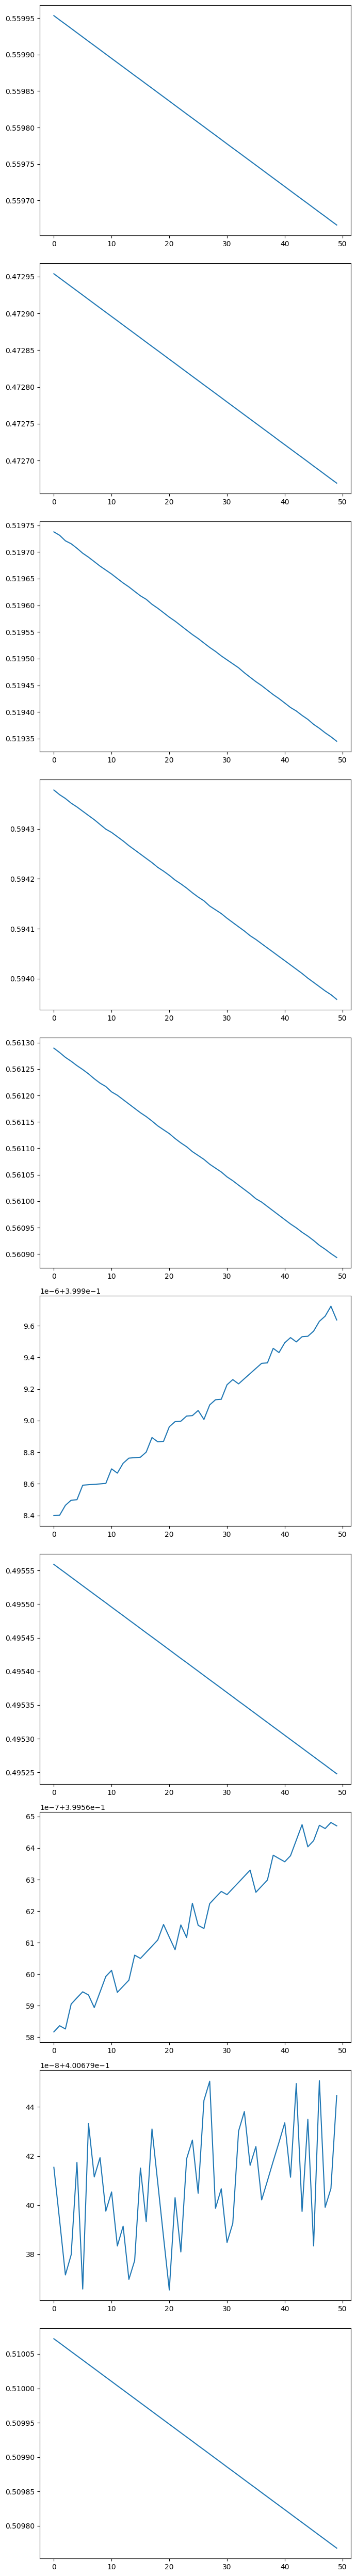

In [132]:
import pickle

# Specify the file name for the pickle file
file_name = "parrot.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as file:
    loaded_list = pickle.load(file)

# Print the loaded list
import matplotlib.pyplot as plt
steps = [i for i in range(50)]
fig, axes = plt.subplots(10, 1, figsize=(7, 50))
for i in range(10):
    axes[i].plot(steps, loaded_list[i])
# for i in range(len(loaded_list)):
    
plt.tight_layout()
plt.show()

In [97]:
len(loaded_list[])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2972996280.py, line 1)

In [ ]:
min =  100
min_i = 0
for i in range(len(loaded_list[0])):
    if(loaded_list[0][i]<min):
        min = loaded_list[0][i]
        min_i = i

In [ ]:
min,min_i

In [44]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # Define the layers
        self.input_layer = nn.Linear(1, 1)
        self.output_layer = nn.Linear(1, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0] 
        gradients_first_derivative = []
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0]
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
        return output,grad_output,grad_grad_output
    def C_AB(self,):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
        return self.C_AB() +  P[0]*(abs(output_time0 - omega_1)) +\
                          P[1]*(abs(grad_output_time0)) +\
                          P[2]*(abs(grad_grad_output_time0)) +\
                          P[3]*(abs(output_timetau - omega_2)) +\
                          P[4]*(abs(grad_output_timetau)) +\
                          P[5]*(abs(grad_grad_output_timetau)) +\
                          P[6]*reLU(output_time0-output_timetau)    
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
   
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 



In [45]:
net = CustomNet()


In [46]:
gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a =  net.calculate_gradients_param(0)

RuntimeError: mat1 and mat2 must have the same dtype

In [43]:
grad_grad_output_a

tensor([[3.2260e-05]], grad_fn=<TBackward0>)

In [12]:
list(net.parameters())

[Parameter containing:
 tensor([[0.3904]], requires_grad=True),
 Parameter containing:
 tensor([0.1675], requires_grad=True),
 Parameter containing:
 tensor([[-0.0412]], requires_grad=True),
 Parameter containing:
 tensor([-0.3184], requires_grad=True)]

In [37]:
z = 1/(1 + np.exp(-0.1675))
print(z*(1-z))
print(z*(1-z)*(1-2*z))

0.24825465141573866
-0.02074285249715165


In [31]:
-(z*0.0412)-0.3184
# A2

-0.34072122761448587

In [36]:
z = 1/(1 + np.exp(0.34072122761448587))
print(z*(1-z))
print(z*(1-z)*(1-2*z))

0.2428824274653509
0.04098189547103579


In [42]:
-0.0412*0.3904*0.3904*((-0.02074285249715165*0.2428824274653509) + (0.24825465141573866 * 0.24825465141573866 * 0.04098189547103579))



1.5775970847999013e-05

In [ ]:
# import matplotlib.pyplot as plt
# import numdifftools as nd
# import progressbar
# import numpy as np
# import math

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import time
# import numpy as np
# import pickle

# def coth(x):
#     return 1 / math.tanh(x)
# plank_constant = 1
# tau = 15
# omega_1 = 0.1
# omega_2 = 0.5
# beta_1 = 1.0
# beta_2 = 0.75
# adam_beta_1 = 0.9
# adam_beta_2 = 0.999
# adam_learning_rate = 0.001
# adam_epsilon = 1e-8
# constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

# def reLU(val):
#   return np.maximum(0, val)
# def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=999):
#     h = (b - a) / n
#     integral_sum = func(a) + func(b)  
    
#     for i in range(1, n):
#         x_i = a + i * h
#         if i % 3 == 0:
#             integral_sum += 2 * func(x_i)  
#         else:
#             integral_sum += 3 * func(x_i) 
    
#     integral_approximation = (3 * h / 8) * integral_sum
#     return integral_approximation


# def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
#     val = torch.ones_like(val_theta) * val
#     val_1 = torch.ones_like(val_theta) * val_1
#     val_2 = torch.ones_like(val_theta) * val_2
#     sign_integrand = (-0.75)*(val_1**2)/(val**2) + (0.5)*(val_2/val)
#     sign = torch.where(sign_integrand > 0, torch.tensor(1), torch.tensor(-1))
    
#     return ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
#           (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))*sign
# def Cab_derivative_wrt_param(integral_part_derivative_wrt_param):
#     return constant_part*integral_part_derivative_wrt_param



# class CustomNet(nn.Module):
#     def __init__(self, input_size):
#         super(CustomNet, self).__init__()
#         # Define the layers
#         self.input_layer = nn.Linear(input_size, 100)
#         self.hidden_layer1 = nn.Linear(100, 100)
#         self.hidden_layer2 = nn.Linear(100, 100)
#         self.hidden_layer3 = nn.Linear(100, 100)
#         self.output_layer = nn.Linear(100, 1)

#     def forward(self, x):
#         # Define the forward pass
#         x = torch.sigmoid(self.input_layer(x))
#         x = torch.sigmoid(self.hidden_layer1(x))
#         x = torch.sigmoid(self.hidden_layer2(x))
#         x = torch.sigmoid(self.hidden_layer3(x))
#         x = torch.sigmoid(self.output_layer(x))
#         return x
    
#     def calculate_gradients_param(self,t):
#         input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
#         output = self.forward(input_data)
#         parameters = list(self.parameters())
#         gradients_zeroth_derivative = []
#         for param in parameters:
#             gradient_0th = torch.autograd.grad(output, param, retain_graph=True)
#             gradients_zeroth_derivative.append(gradient_0th[0])
#         grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0] 
#         gradients_first_derivative = []
#         for param in parameters:
#             gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True)
#             gradients_first_derivative.append(gradient_1st[0])
#         grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
#         gradients_second_derivative = []
#         for param in parameters:
#             gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True)
#             gradients_second_derivative.append(gradient_2nd[0])
#         return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
#     def gradients_wrt_time(self,t):
#         input_data = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
#         output = self.forward(input_data)
#         grad_output = torch.autograd.grad(output, input_data, create_graph=True)[0]
#         grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True)[0]
#         return output,grad_output,grad_grad_output
#     def C_AB(self,):
#         Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
#         return constant_part*Integral_part
#     def cost_function(self,P):
#         output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
#         output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
#         output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
#         output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
#         return self.C_AB() +  P[0]*(abs(output_time0 - omega_1)) +\
#                           P[1]*(abs(grad_output_time0)) +\
#                           P[2]*(abs(grad_grad_output_time0)) +\
#                           P[3]*(abs(output_timetau - omega_2)) +\
#                           P[4]*(abs(grad_output_timetau)) +\
#                           P[5]*(abs(grad_grad_output_timetau)) +\
#                           P[6]*reLU(output_time0-output_timetau)    
#     def Integrand_function(self,t,sign=False):
#         val , val_1 , val_2 = self.gradients_wrt_time(t)   
#         val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
   
#         return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 
    
# net = CustomNet(input_size=1)
# net.cost_function(P_val[0])
    

In [ ]:
print(adam_learning_rate * m_hat / (torch.sqrt(v_hat) + adam_epsilon))

In [ ]:
print(m_hat)

In [ ]:
print(v_hat)

In [90]:
import matplotlib.pyplot as plt
import numdifftools as nd
import progressbar
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pickle

def sign_val(a):
    if(a>1e-4):
        return 1
    elif(a<-1e-4):
        return -1
    else:
        return 0
def coth(x):
    return 1 / math.tanh(x)
plank_constant = 1
tau = 5
omega_1 = 0.1
omega_2 = 0.5
beta_1 = 1.0
beta_2 = 0.75
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_learning_rate = 0.05
adam_epsilon = 1e-8
constant_part = coth(beta_1*plank_constant*omega_1)*plank_constant*math.sqrt(3)/(4*tau)

def reLU(val):
  return np.maximum(0, val)
def reLU_derivative(z):
    if(z>0):
        return 1
    if(z<0):
        return 0
    if(z==0):
        print("z = 0 , NN is giving same value at both zero and tau ")
def simpsons_3_8_rule_integration(func, a = 0, b = 0, n=999):
    h = (b - a) / n
    integral_sum = func(a) + func(b)  
    
    for i in range(1, n):
        x_i = a + i * h
        if i % 3 == 0:
            integral_sum += 2 * func(x_i)  
        else:
            integral_sum += 3 * func(x_i) 
    
    integral_approximation = (3 * h / 8) * integral_sum
    return integral_approximation


def function_derivative_integrand(val,val_1,val_2,val_theta,val_1_theta,val_2_theta):
    val = torch.ones_like(val_theta) * val
    val_1 = torch.ones_like(val_theta) * val_1
    val_2 = torch.ones_like(val_theta) * val_2
    sign_integrand = (-0.75)*(val_1**2)/(val**2) + (0.5)*(val_2/val)
    sign = torch.where(sign_integrand > 0, torch.tensor(1), torch.tensor(-1))
    
    return ((-0.75) * ((2 * val_1 * (val ** (-3)) * val_1_theta) + (-3) * (val_1 ** 2) * ((val ** (-4)) * val_theta)) +
          (0.5) * (((val ** (-2)) * val_2_theta) + ((-2) * (val ** (-3)) * val_theta * val_2)))*sign
def Cab_derivative_wrt_param(integral_part_derivative_wrt_param):
    return constant_part*integral_part_derivative_wrt_param



class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # Define the layers
        
        self.input_layer = nn.Linear(10, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.sigmoid(self.input_layer(x))
        x = torch.sigmoid(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x
    
    def calculate_gradients_param(self,t):
        input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
        # input_d = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        parameters = list(self.parameters())
        gradients_zeroth_derivative = []
        for param in parameters:
            gradient_0th = torch.autograd.grad(output, param, retain_graph=True , allow_unused = True)
            gradients_zeroth_derivative.append(gradient_0th[0])
        grad_output = torch.autograd.grad(output, input_data, create_graph=True,allow_unused = True)
        grad_output = grad_output[0][0][1] 
        gradients_first_derivative = []
        # print(grad_output)
        for param in parameters:
            gradient_1st = torch.autograd.grad(grad_output, param, retain_graph=True,allow_unused = True)
            gradients_first_derivative.append(gradient_1st[0])
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True,allow_unused = True)
        grad_grad_output = grad_grad_output[0][0][1]
        gradients_second_derivative = []
        for param in parameters:
            gradient_2nd = torch.autograd.grad(grad_grad_output, param, retain_graph=True,allow_unused = True)
            gradients_second_derivative.append(gradient_2nd[0])
        return  gradients_zeroth_derivative , gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output
    def gradients_wrt_time(self,t):
        input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
        # input_d = torch.tensor([[t]], dtype=torch.float32, requires_grad=True)
        output = self.forward(input_data)
        grad_output = torch.autograd.grad(output, input_data, create_graph=True,allow_unused = True)
        grad_output = grad_output[0][0][1] 
        grad_grad_output = torch.autograd.grad(grad_output, input_data, create_graph=True,allow_unused = True)
        grad_grad_output = grad_grad_output[0][0][1]
        return output,grad_output,grad_grad_output
    def C_AB(self,):
        Integral_part = simpsons_3_8_rule_integration(self.Integrand_function , b = tau)
        return constant_part*Integral_part
    def cost_function(self,P):
        output_time0,grad_output_time0,grad_grad_output_time0 = self.gradients_wrt_time(0)
        output_time0,grad_output_time0,grad_grad_output_time0 = output_time0.item(),grad_output_time0.item(),grad_grad_output_time0.item()
        output_timetau,grad_output_timetau,grad_grad_output_timetau = self.gradients_wrt_time(tau)
        output_timetau,grad_output_timetau,grad_grad_output_timetau = output_timetau.item(),grad_output_timetau.item(),grad_grad_output_timetau.item()
        return self.C_AB() + P[0]*(abs(output_time0 - omega_1)) +\
                          P[1]*(abs(grad_output_time0)) +\
                          P[2]*(abs(grad_grad_output_time0)) +\
                          P[3]*(abs(output_timetau - omega_2)) +\
                          P[4]*(abs(grad_output_timetau)) +\
                          P[5]*(abs(grad_grad_output_timetau)) +\
                          P[6]*reLU(output_time0-output_timetau)    
        # return  P[3]*(abs(output_timetau - omega_2)) + P[0]*(abs(output_time0 - omega_1))
        # return self.C_AB()
    def Integrand_function(self,t,sign=False):
        val , val_1 , val_2 = self.gradients_wrt_time(t)   
        val , val_1 , val_2 = val.item() , val_1.item() , val_2.item()
   
        return (abs( ( ( -3*(val_1**2) )/( 4*(val**2) ) ) + (val_2 / (2*val )) ) /   val ) 


P_val = np.array([
    [0.01, 0.01, 0.01, 0.95, 0.01, 0.01, 2],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 2],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 2],
    [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 2]
])
cost_fun = []
param_step_1 = []
bar = progressbar.ProgressBar(maxval=1000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for initial_conditions in range(1):
    bar.update(initial_conditions+1)
    net = CustomNet()
    parameters = list(net.parameters())
    # file_name = "para_tau_30.pkl"
    # Open the file in binary read mode
    # with open(file_name, "rb") as file:
    #     param_step = pickle.load(file) 
    # i = 0
    # for param in net.parameters():
            
    # # if(a==0):
    # #     a = 1
    # # print(param.data)
    #     # print(i)
    #     param.data = param_step[0][i]
        # i =  i + 1
    # print(i)    
    loss_func_param_gradient = [torch.zeros_like(param) for param in parameters]
    cost_fun.append([])

    for pass_idx in range(4):
        m_curr = [torch.zeros_like(param) for param in parameters]
        v_curr = [torch.zeros_like(param) for param in parameters]
        m_prev = [torch.zeros_like(param) for param in parameters]
        v_prev = [torch.zeros_like(param) for param in parameters]
        t = 0
        P = P_val[pass_idx]
        # for i in range (len(m)):
        #     print(m_curr[i].shape)
        for step in range(500):
            t = t + 1
            n=99
            h = tau/n
            a = 0
            b = tau
            gradients_zeroth_derivative_a, gradients_first_derivative_a , gradients_second_derivative_a , output_a , grad_output_a , grad_grad_output_a = net.calculate_gradients_param(a)
            gradients_zeroth_derivative_b, gradients_first_derivative_b , gradients_second_derivative_b , output_b , grad_output_b , grad_grad_output_b  = net.calculate_gradients_param(b)
            
            for i in range(len(loss_func_param_gradient)):
                
                loss_func_param_gradient[i] = function_derivative_integrand(output_a.item(),grad_output_a.item(),grad_grad_output_a.item(),gradients_zeroth_derivative_a[i],gradients_first_derivative_a[i],gradients_second_derivative_a[i]) + \
                function_derivative_integrand(output_b.item(),grad_output_b.item(),grad_grad_output_b.item(),gradients_zeroth_derivative_b[i],gradients_first_derivative_b[i],gradients_second_derivative_b[i])
            for integration_step in range(n):
                x_i = a + integration_step * h
                gradients_zeroth_derivative, gradients_first_derivative , gradients_second_derivative , output , grad_output , grad_grad_output = net.calculate_gradients_param(x_i)
                for i in range(len(loss_func_param_gradient)):    
                    if (integration_step+1) % 3 == 0:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 2*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
                    else:
                        loss_func_param_gradient[i] = loss_func_param_gradient[i] + 3*function_derivative_integrand(output.item(),grad_output.item(),grad_grad_output.item(),gradients_zeroth_derivative[i],gradients_first_derivative[i],gradients_second_derivative[i])
            
            for j in range(len(loss_func_param_gradient)):    
                loss_func_param_gradient[j] = (3 * h / 8) * loss_func_param_gradient[j]  
            
            
            for j in range(len(loss_func_param_gradient)):  
                term_1 = sign_val(output_a.item()-omega_1)*P[0]*(gradients_zeroth_derivative_a[j])
                term_2 = sign_val(grad_output_a.item())*P[1]*(gradients_first_derivative_a[j])
                term_3 = sign_val(grad_grad_output_a.item())*P[2]*(gradients_second_derivative_a[j])
                term_4 = sign_val(output_b.item()-omega_2)*P[3]*(gradients_zeroth_derivative_b[j])
                
                term_5 = sign_val(grad_output_b.item())*P[4]*(gradients_first_derivative_b[j])
                term_6 = sign_val(grad_grad_output_b.item())*P[5]*(gradients_second_derivative_b[j])
                term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])*reLU_derivative(output_a.item()-output_b.item())
                if(reLU_derivative(output_a.item()-output_b.item())):
                    term_7 = P[6]*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                else:
                    term_7 = 0*(gradients_zeroth_derivative_a[j] - gradients_zeroth_derivative_b[j])
                loss_func_param_gradient[j] = loss_func_param_gradient[j] + term_4 + term_1 + term_2 + term_3 + term_5 + term_6 + term_7



            for i in range(len(loss_func_param_gradient)):   

                # m_curr[i] = (adam_beta_1 * m_prev[i] + (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = (adam_beta_2 * v_prev[i] + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                
                # m_hat = m_curr[i] / (1 - adam_beta_1**t)
                # v_hat = v_curr[i] / (1 - adam_beta_2**t)
                # m_prev[i] = m_curr[i]
                # v_prev[i] = v_curr[i]
                
                # m_curr[i] = ((adam_beta_1 * m_prev[i])- (1 - adam_beta_1) * loss_func_param_gradient[i] )
                # v_curr[i] = ((adam_beta_2 * v_prev[i]) + (1 - adam_beta_2) * ( loss_func_param_gradient[i]** 2))
                # delta_w = (-adam_learning_rate)*m_curr[i]*loss_func_param_gradient[i] / (torch.sqrt(v_curr[i]) + adam_epsilon)
                # print(v_curr[i])

                # parameters[i] = parameters[i] - delta_w
                # parameters[i] = parameters[i] - (adam_learning_rate * m_hat / (torch.sqrt(v_hat) + adam_epsilon))
                parameters[i] = parameters[i] - (adam_learning_rate)*loss_func_param_gradient[i]
            i = 0    
            for param in net.parameters():
                
                # if(a==0):
                #     a = 1
                
                param.data = parameters[i]
                i = i + 1
            cost_fun[initial_conditions].append(net.cost_function(P_val[0]))
    param_step_1.append(parameters)

with open('parrot.pkl', 'wb') as f:
    pickle.dump(cost_fun, f)

In [ ]:
0.0484, -0.0884,  0.0006,  

In [54]:
with open('para_tau_30_extra_trainoing_with_term_1_to_7.pkl', 'wb') as f:
    pickle.dump(param_step_1, f)

In [50]:
# with open('para_268_min_1000stepsX2.pkl', 'wb') as f:file_name = "para_best_yet.pkl"
import pickle
file_name = "para_tau_30_small_learning_rate.pkl"
# Open the file in binary read mode
with open(file_name, "rb") as file:
    param_step = pickle.load(file)    

# Open the file in binary read mode
# with open(file_name, "rb") as file:
#     param_step = pickle.load(file)    

In [55]:
len(param_step[0])

8

In [42]:
i = 0
for param in net.parameters():
            
    # if(a==0):
    #     a = 1
    # print(param.data)

    param.data = param_step[1][i]
    i =  i + 1



In [56]:
for param in net.parameters():
    print(param.data.shape)

torch.Size([100, 10])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [91]:
time = np.arange(0, 6, 0.01)
sigma = []
# grad = []
for t in time:
    grad  =  net.gradients_wrt_time(t)
    sigma.append(np.sqrt( ((grad[0].item())**2) - 0.75*(((grad[1].item())**2)/((grad[0].item())**2)) + 0.5*((grad[2].item())/(grad[0].item())) ))

In [92]:
import numpy as np
import matplotlib.pyplot as plt
omega = []
time = np.arange(0, 6, 0.01)


for t in time:
    input_data = torch.tensor([[1,t,t**2,t**3,t**4,t**5,t**6,t**7,t**8,t**9]], dtype=torch.float32, requires_grad=True)
    omega.append(net.forward(input_data).item())

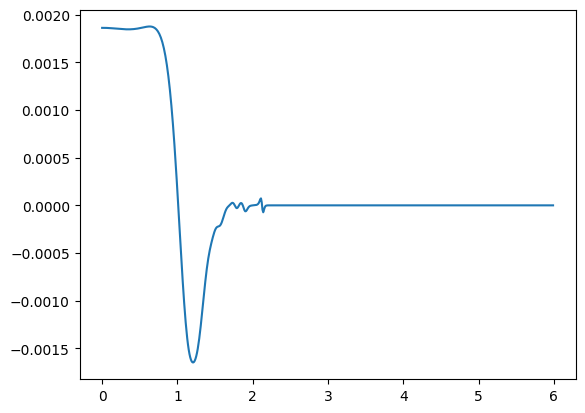

In [93]:
diff = []
for i in range(len(sigma)):
    diff.append(sigma[i]-omega[i])
plt.plot(time,diff)

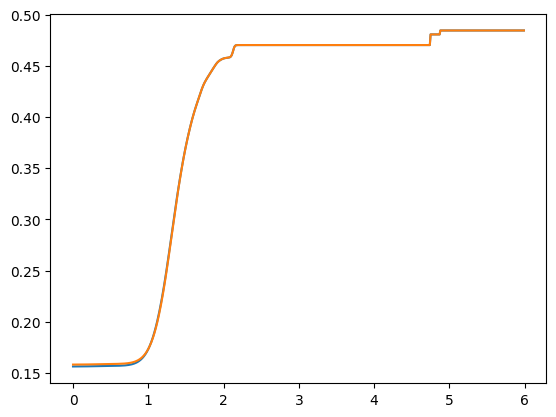

In [94]:
plt.plot(time,omega)
plt.plot(time,sigma)

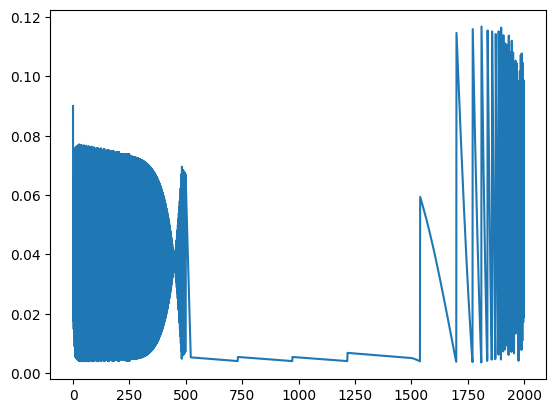

In [95]:
import pickle

# Specify the file name for the pickle file
# file_name = "parrot.pkl"

# # Open the file in binary read mode
# with open(file_name, "rb") as file:
#     loaded_list = pickle.load(file)

# Print the loaded list
import matplotlib.pyplot as plt
steps = [i for i in range(2000)]
plt.plot(steps,cost_fun[0])
# fig, axes = plt.subplots(1, 1, figsize=(7, 50))
# for i in range(1):
#     axes[i].scatter(steps, cost_fun[i])
# plt.show()
